# Imports

In [6]:
#loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feather as ft
import sys

todo_AddRPC = True
if sys.platform.startswith('win'):
    InputDir  = "C:/LustreSync/LAU Brian - 2024_GBMOV/Data/pq_wide/"
    todo_GridSearch = False
else :
    InputDir  = "/network/lustre/iss02/home/mathieu.yeche/Cluster/"
    todo_GridSearch = True

# arrow query
query = ft.read_dataframe(InputDir + "T0_AS_SM_OFF.feather")
query_save = query

In [7]:
query = query_save

## Preprocessing

Prepare the different datasets of part 1

In [8]:

query = query[query['Time'] > 0].drop(columns=['Protocol', 'Condition', 'Side_firststep', 'index'])
if not todo_AddRPC:
    query.drop(columns=['RPC.1','RPC.2','RPC.3','RPC.4','RPC.5'], inplace=True)
else :
    query[['RPC.1','RPC.2','RPC.3','RPC.4','RPC.5']] = StandardScaler().fit_transform(query[['RPC.1','RPC.2','RPC.3','RPC.4','RPC.5']])
    query[['Power']] = StandardScaler().fit_transform(query[['Power']])
q01   = query[(query['Meta_FOG'] == 0) | (query['Meta_FOG'] == 1)]
q12   = query[(query['Meta_FOG'] == 1) | (query['Meta_FOG'] == 2)]


In [9]:
# A) LFO in Freezers/Non-Freezers marg_loc
LFO_01_mloc_alltimepoint = q01[(q01['Freq'] >= 4) & (q01['Freq'] <= 12)].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()

# B) LB in Freezers/Non-Freezers marg_loc
LB_01_mloc_alltimepoint = q01[(q01['Freq'] >= 13) & (q01['Freq'] <= 23)].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()

# C) LB in Freezers/Non-Freezers AS
LB_01_AS_alltimepoint = q01[(q01['Freq'] >= 13) & (q01['Freq'] <= 23) & (q01['Loc'] == "AS")].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()

# D) LB in Freezers/Non-Freezers SM
LB_01_SM_alltimepoint = q01[(q01['Freq'] >= 13) & (q01['Freq'] <= 23) & (q01['Loc'] == "SM")].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()

# E) HB with/without FOG AS
HB_12_AS_alltimepoint = q12[(q12['Freq'] >= 27) & (q12['Freq'] <= 35) & (q12['Loc'] == "AS")].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()

# F) HB with/without FOG SM
HB_12_SM_alltimepoint = q12[(q12['Freq'] >= 27) & (q12['Freq'] <= 35) & (q12['Loc'] == "SM")].drop(columns=['Loc']).groupby(['GoNogo', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()


Balance

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

test_size = 0.2
under = RandomUnderSampler(sampling_strategy='majority')
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
  

# Resultats

## Partie 1 : Ajout aux figures

For each, 4 modalities : 
- Modele de base + All timepoints
- GridSearch + All timepoints
- Modele de base + seulement 2 TP
- GridSearch + seulement 2 TP

##### A) LFO in Freezers/Non-Freezers marg_loc

In [276]:
# A definir : 
DF_to_use = LFO_01_mloc_alltimepoint
TimepointOne = 0.49
TimepointTwo = 1.0
RPC_to_use = 'RPC.1'
if todo_AddRPC:
    TimepointTwo = np.nan

# Automatique : 

Basique

In [277]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()

Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.6501501501501501


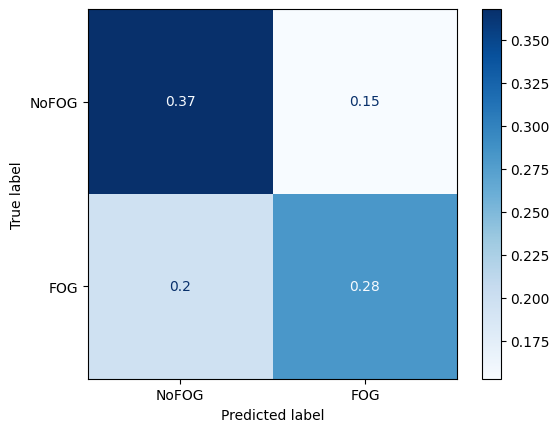

In [278]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [ ]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

Best hyperparameters: {'C': 10, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.6760817307692307
Root mean squared error (RMSE): 0.569138181139492  (Lower is better)


2 Timepoints uniquement

In [280]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()

Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.5945945945945946


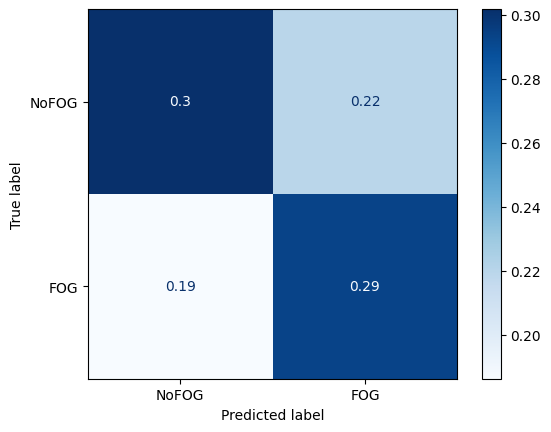

In [281]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

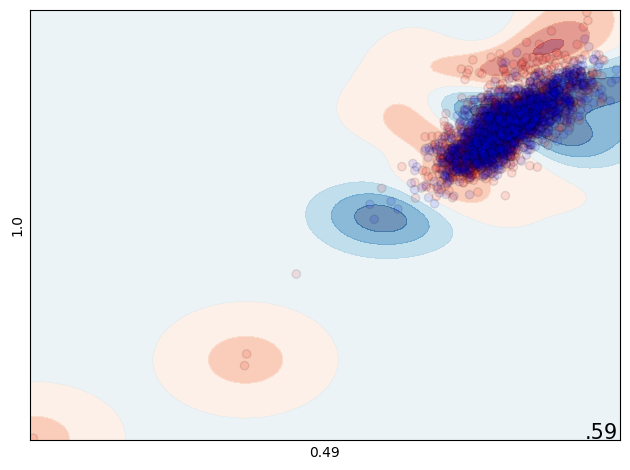

In [282]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5

ax = plt.subplot(1, 1, 1)

DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


Best hyperparameters: {'C': 0.1, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.5946514423076923
Root mean squared error (RMSE): 0.6366698969578408  (Lower is better)


In [284]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### B1)  LB in Freezers/Non-Freezers marg_loc RPC2

In [285]:
# A definir : 
DF_to_use = LB_01_mloc_alltimepoint
TimepointOne = 0.49
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan
    
# Automatique : 

Basique

In [286]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.6111111111111112


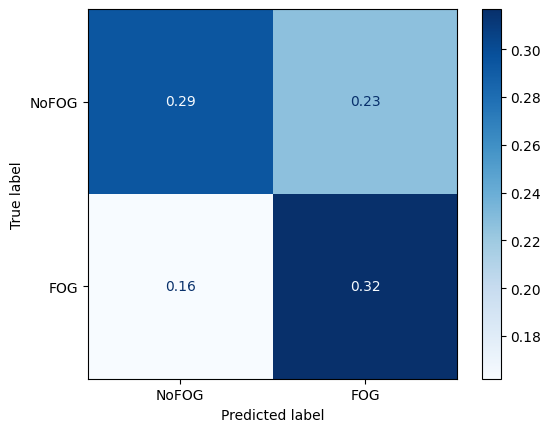

In [287]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [288]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

2 Timepoints uniquement

In [289]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.5615615615615616


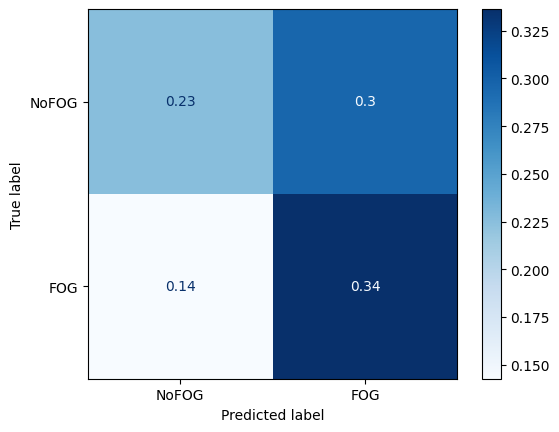

In [290]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

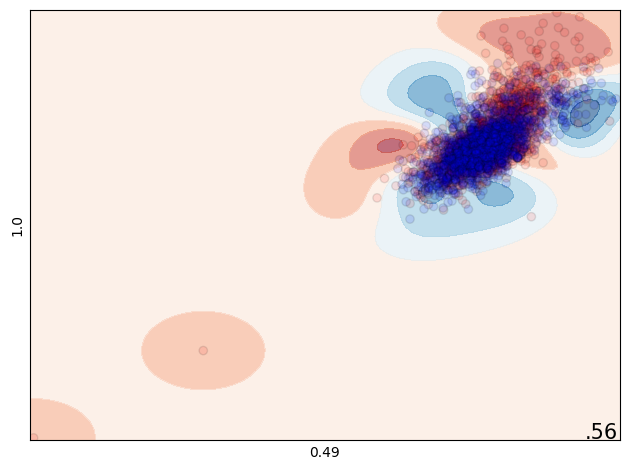

In [291]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [292]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


In [293]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### B2) LB in Freezers/Non-Freezers marg_loc RPC.5

In [294]:
# A definir : 
DF_to_use    = LB_01_mloc_alltimepoint
TimepointOne = 0.49
TimepointTwo = 1.0
RPC_to_use   = 'RPC.5'
if todo_AddRPC:
    TimepointTwo = np.nan

# Automatique : 

Basique

In [295]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.6231231231231231


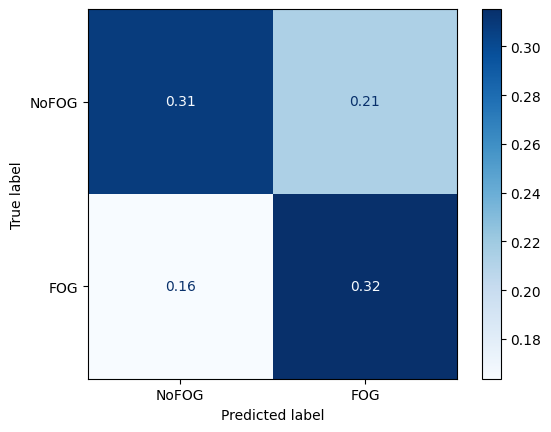

In [296]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [297]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

2 Timepoints uniquement

In [298]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Counter({0.0: 5558, 1.0: 1664})
Accuracy: 0.5630630630630631


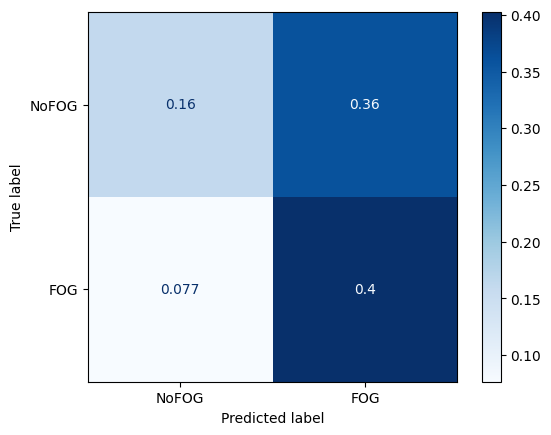

In [299]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

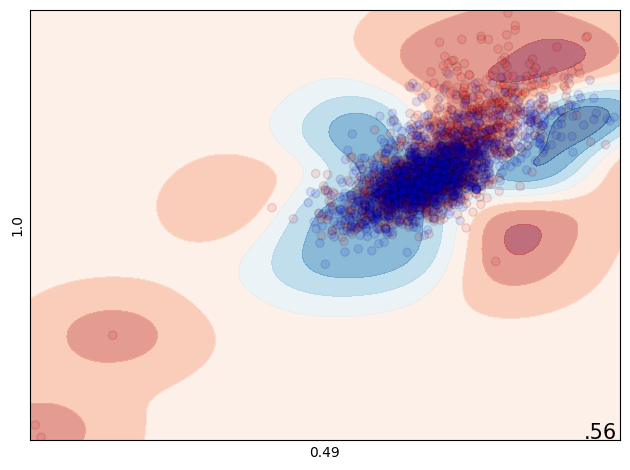

In [300]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [301]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


In [302]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### C) LB in Freezers/Non-Freezers AS

In [303]:
# A definir : 
DF_to_use = LB_01_AS_alltimepoint
TimepointOne = 0.49
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan

# Automatique : 

Basique

In [304]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Counter({0.0: 3331, 1.0: 754})
Accuracy: 0.6423841059602649


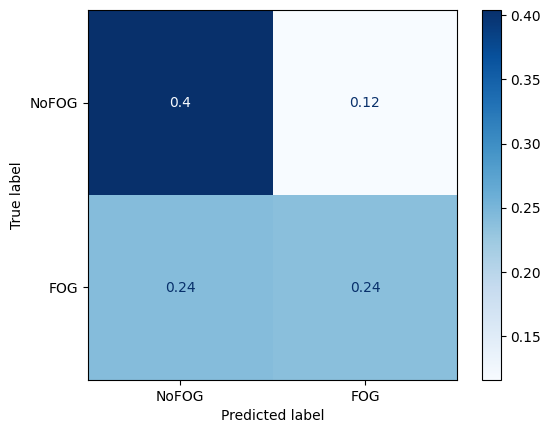

In [305]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [306]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

2 Timepoints uniquement

In [307]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Counter({0.0: 3331, 1.0: 754})
Accuracy: 0.5364238410596026


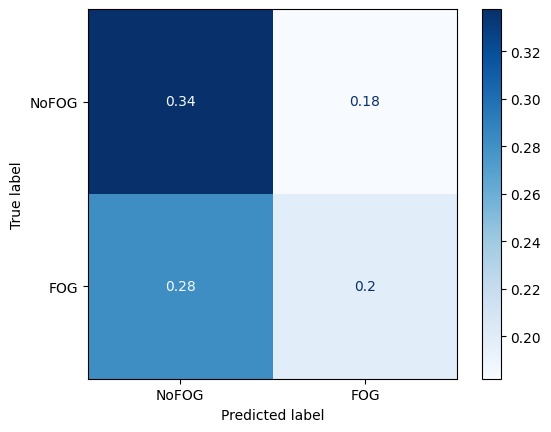

In [308]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

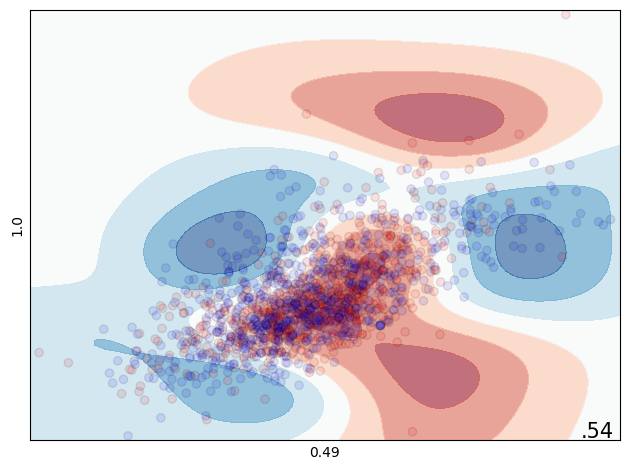

In [309]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [310]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


In [311]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### D) LB in Freezers/Non-Freezers SM

In [312]:
# A definir : 
DF_to_use = LB_01_SM_alltimepoint
TimepointOne = 0.49
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan

# Automatique : 

Basique

In [313]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Counter({0.0: 3118, 1.0: 1226})
Accuracy: 0.6191446028513238


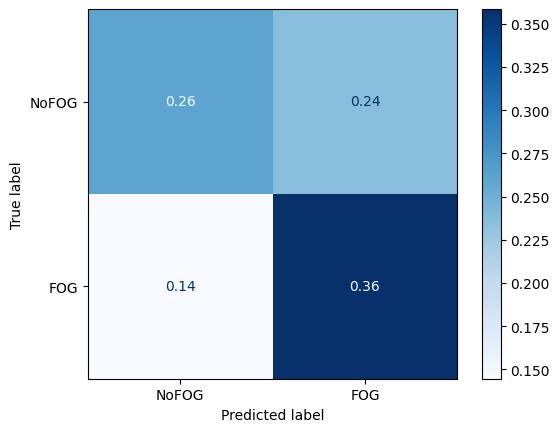

In [314]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [315]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

2 Timepoints uniquement

In [316]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Counter({0.0: 3118, 1.0: 1226})
Accuracy: 0.5539714867617108


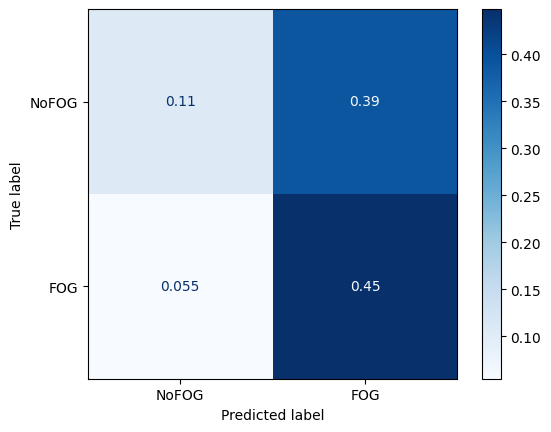

In [317]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
print(Counter(y))
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

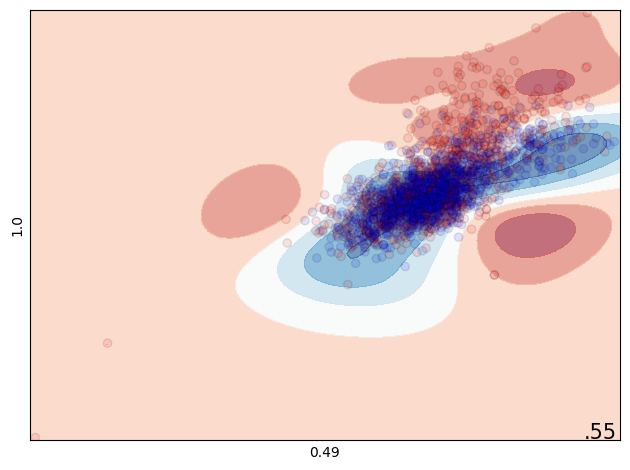

In [318]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
  
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [319]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


In [320]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### E) HB with/without FOG AS

In [ ]:
import numpy as np
# A definir : 
# Beware the undersampler 
DF_to_use = HB_12_AS_alltimepoint
TimepointOne = 1.48
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan

%autosave 20
# Automatique :


Basique

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Balancing

In [ ]:
balanced_data = pd.DataFrame()
grouped_data = DF.groupby('Subject')
for subject, group in grouped_data:
    if sum(group['Meta_FOG'] == 2) < 1:
        continue
    group.columns = group.columns.astype(str)
    group, _ = under.fit_resample(group, group['Meta_FOG'])
    balanced_data = pd.concat([balanced_data, group])
balanced_data.reset_index(drop=True, inplace=True)
DF = balanced_data

Accuracy: 0.5925925925925926


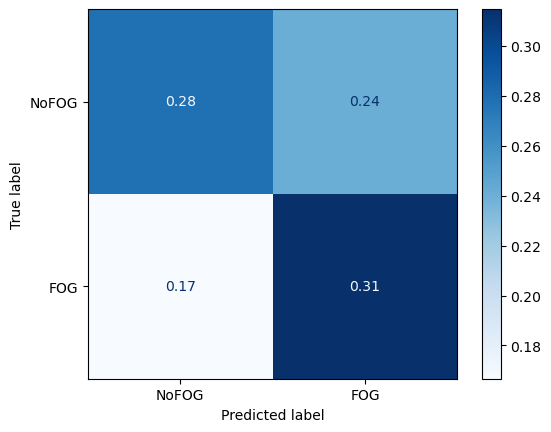

In [ ]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [ ]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

Best hyperparameters: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Accuracy: 0.6777777777777778
Root mean squared error (RMSE): 0.5676462121975467  (Lower is better)


2 Timepoints uniquement

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Balance

In [ ]:
balanced_data = pd.DataFrame()
grouped_data = DF.groupby('Subject')
for subject, group in grouped_data:
    if sum(group['Meta_FOG'] == 2) < 1:
        continue
    group.columns = group.columns.astype(str)
    group, _ = under.fit_resample(group, group['Meta_FOG'])
    balanced_data = pd.concat([balanced_data, group])
balanced_data.reset_index(drop=True, inplace=True)
DF = balanced_data

Accuracy: 0.5


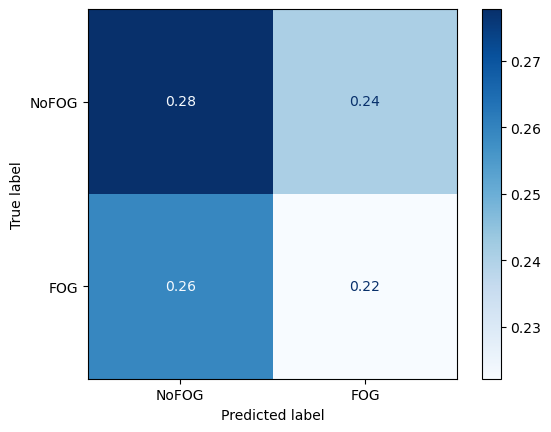

In [ ]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

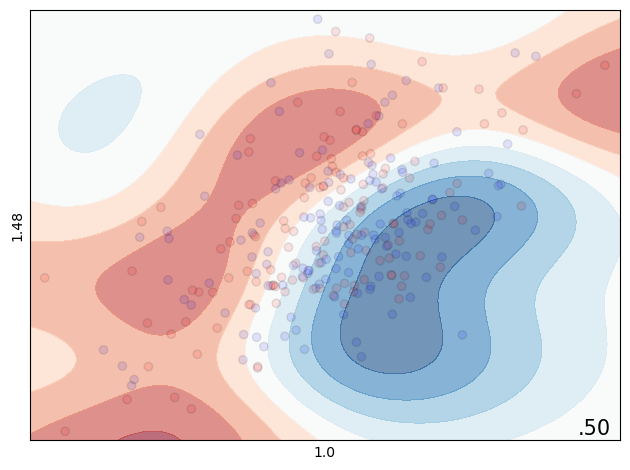

In [ ]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


Best hyperparameters: {'C': 1, 'degree': 1, 'kernel': 'linear'}
Accuracy: 0.5370370370370371
Root mean squared error (RMSE): 0.6804138174397717  (Lower is better)


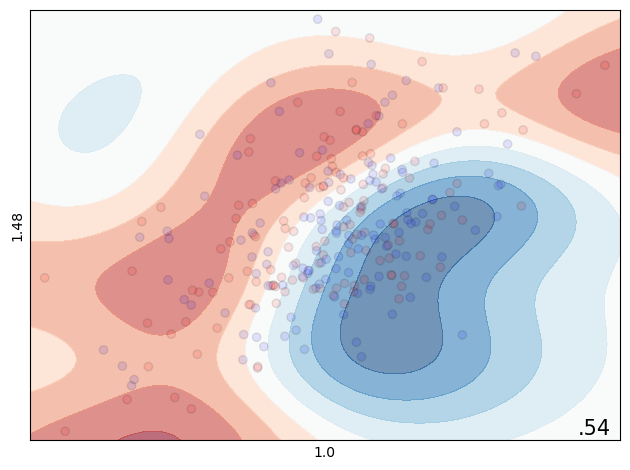

In [ ]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### F) HB with/without FOG SM

In [ ]:
import numpy as np
# A definir : 
# Beware the undersampler 
DF_to_use = HB_12_SM_alltimepoint
TimepointOne = 1.48
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan
    
# Automatique :


Basique

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Balancing

In [ ]:
balanced_data = pd.DataFrame()
grouped_data = DF.groupby('Subject')
for subject, group in grouped_data:
    if sum(group['Meta_FOG'] == 2) < 1:
        continue
    if sum(group['Meta_FOG'] == 1) < 1:
        continue
    group.columns = group.columns.astype(str)
    group, _ = under.fit_resample(group, group['Meta_FOG'])
    balanced_data = pd.concat([balanced_data, group])
balanced_data.reset_index(drop=True, inplace=True)
DF = balanced_data

Accuracy: 0.625


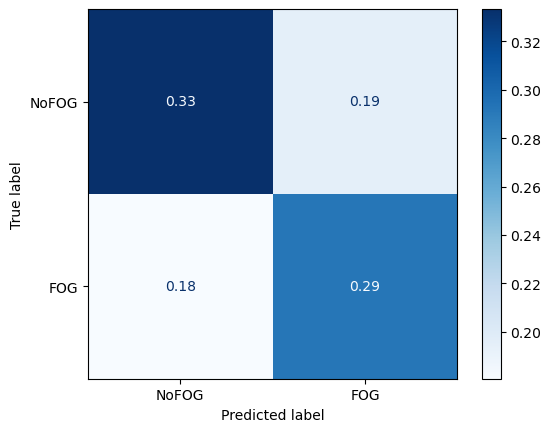

In [ ]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [ ]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

Best hyperparameters: {'C': 1, 'degree': 1, 'kernel': 'linear'}
Accuracy: 0.7527777777777778
Root mean squared error (RMSE): 0.49721446300587663  (Lower is better)


2 Timepoints uniquement

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


balancing

Accuracy: 0.6111111111111112


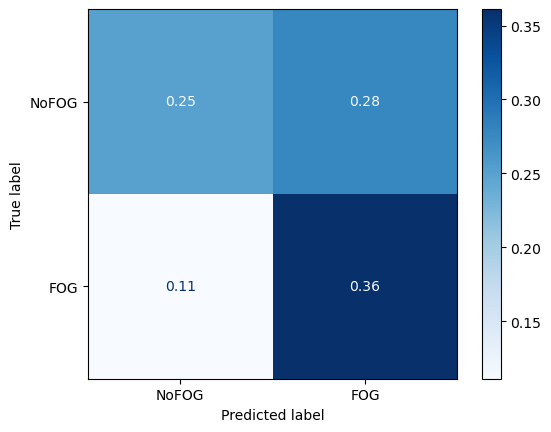

In [ ]:
balanced_data = pd.DataFrame()
grouped_data = DF.groupby('Subject')
for subject, group in grouped_data:
    if sum(group['Meta_FOG'] == 2) < 1:
        continue
    if sum(group['Meta_FOG'] == 1) < 1:
        continue
    group.columns = group.columns.astype(str)
    group, _ = under.fit_resample(group, group['Meta_FOG'])
    balanced_data = pd.concat([balanced_data, group])
balanced_data.reset_index(drop=True, inplace=True)
DF = balanced_data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

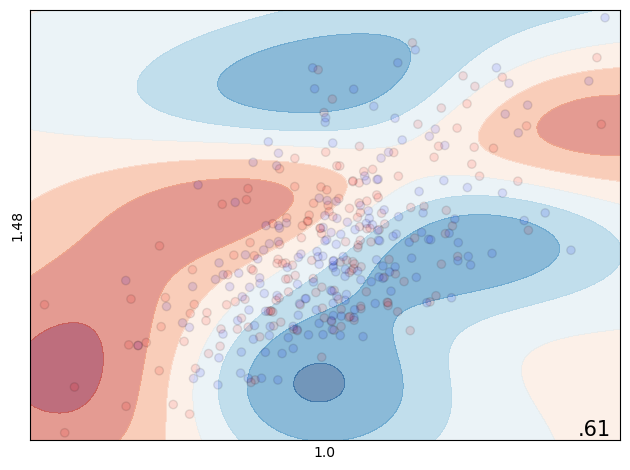

In [ ]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


Best hyperparameters: {'C': 1, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.5361111111111111
Root mean squared error (RMSE): 0.681093891390085  (Lower is better)


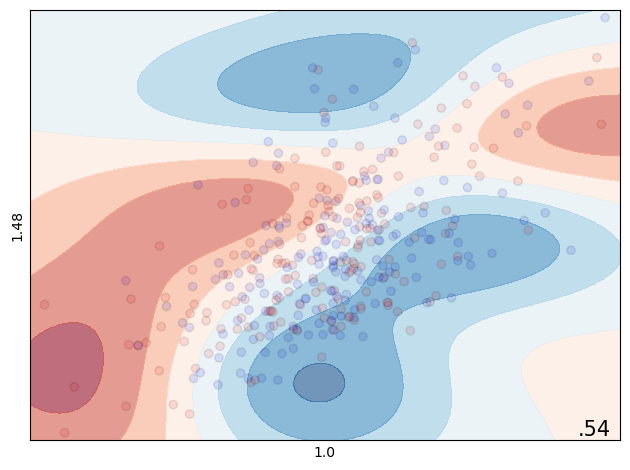

In [ ]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### Ebis) HB with/without FOG AS random balancing

In [ ]:
import numpy as np
# A definir : 
# Beware the undersampler 
DF_to_use = HB_12_AS_alltimepoint
TimepointOne = 1.48
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan
    
# Automatique :


Basique

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Balancing

Accuracy: 0.7941176470588235


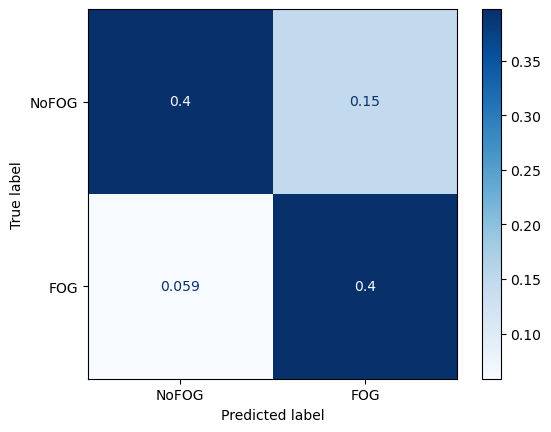

In [ ]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [ ]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

Best hyperparameters: {'C': 10, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.6666666666666666
Root mean squared error (RMSE): 0.5773502691896257  (Lower is better)


2 Timepoints uniquement

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


Balance

Accuracy: 0.7058823529411765


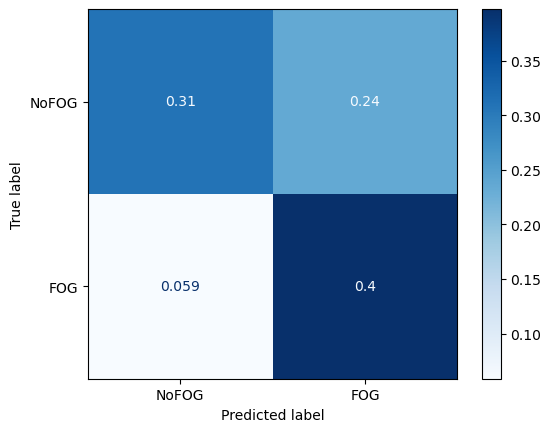

In [ ]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

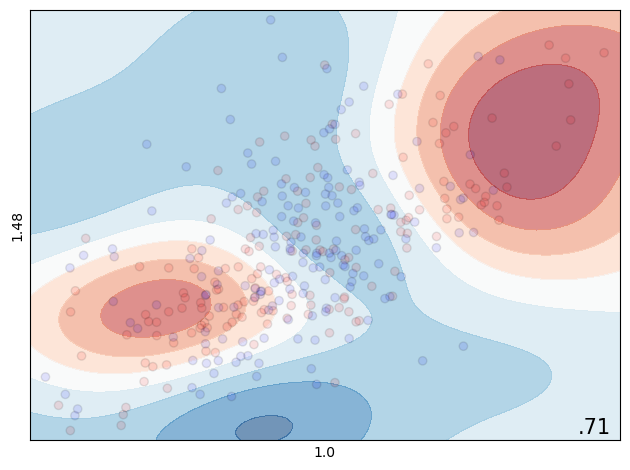

In [ ]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


Best hyperparameters: {'C': 1, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.5922619047619048
Root mean squared error (RMSE): 0.6385437300906612  (Lower is better)


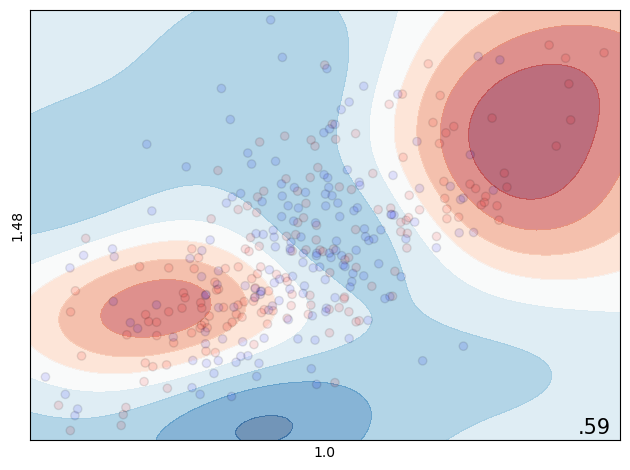

In [ ]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

##### Fbis) HB with/without FOG SM  random balancing

In [ ]:
import numpy as np
# A definir : 
# Beware the undersampler 
DF_to_use = HB_12_SM_alltimepoint
TimepointOne = 1.48
TimepointTwo = 1.0
RPC_to_use = 'RPC.2'
if todo_AddRPC:
    TimepointTwo = np.nan
    
# Automatique :


Basique

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use.pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'              ], columns=['Time'], values='Power').reset_index()


Balancing

Accuracy: 0.5607843137254902


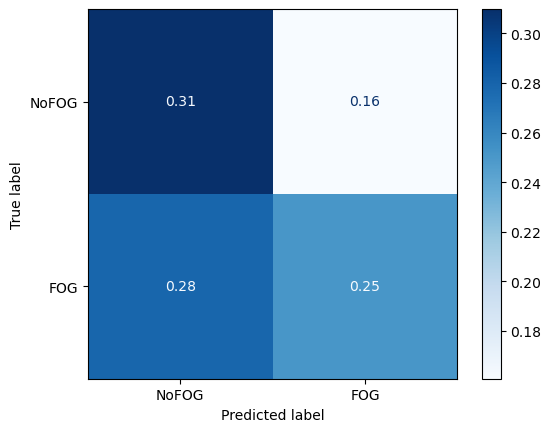

In [ ]:
# Ressample and split the data

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

GridSearch & Leave one out 

In [ ]:
# define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

# create an instance of GridSearchCV and fit the data
if todo_GridSearch:
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')

Best hyperparameters: {'C': 10, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.6768867924528302
Root mean squared error (RMSE): 0.5684304773208152  (Lower is better)


2 Timepoints uniquement

In [ ]:
if todo_AddRPC:
    DF_to_use["RPC_to_use"] = DF_to_use[RPC_to_use]
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG', 'RPC_to_use'], columns=['Time'], values='Power').reset_index()
else:
    DF = DF_to_use[(DF_to_use['Time'] == TimepointOne) | (DF_to_use['Time'] == TimepointTwo)].pivot_table(index=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'], columns=['Time'], values='Power').reset_index()


balancing

Accuracy: 0.592156862745098


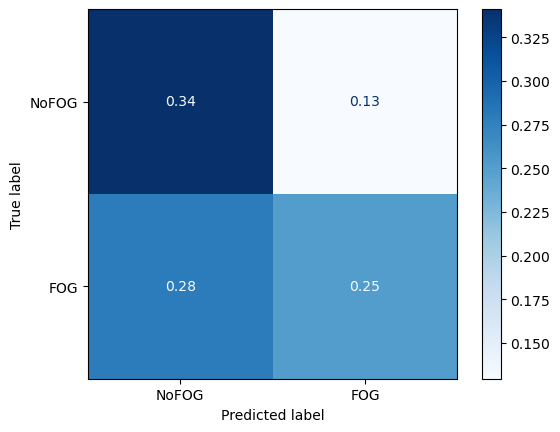

In [ ]:

X = DF.drop(columns=['Subject', 'TrialNum', 'GoNogo', 'Channel', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
X, y = under.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score

print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Representation graphique de la limite de classif

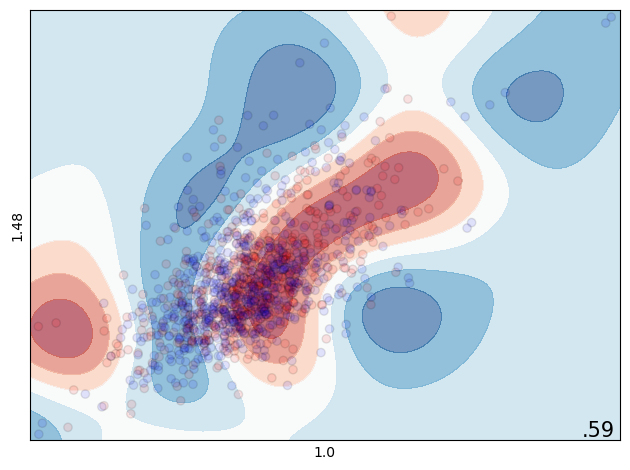

In [ ]:
score = accuracy_score(ytest, ypred)

figure = plt.figure()

x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()


GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3]}

# create an instance of SVM
svc = SVC()

if todo_GridSearch:
    # create an instance of GridSearchCV and fit the data
    loo = LeaveOneOut()
    grid_search = GridSearchCV(svc, param_grid, cv=loo, n_jobs=-1)
    grid_search.fit(X, y)
    bestkernel = grid_search.best_params_['kernel']
    bestdegree = grid_search.best_params_['degree']
    scores = cross_val_score(SVC(**grid_search.best_params_), X, y, cv=loo, n_jobs=-1, scoring='neg_mean_squared_error')
    
    # print the best hyperparameters and the corresponding accuracy score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    print("Root mean squared error (RMSE):", np.sqrt(np.mean(np.absolute(scores))), ' (Lower is better)')


Best hyperparameters: {'C': 1, 'degree': 1, 'kernel': 'rbf'}
Accuracy: 0.5566037735849056
Root mean squared error (RMSE): 0.6658800390574073  (Lower is better)


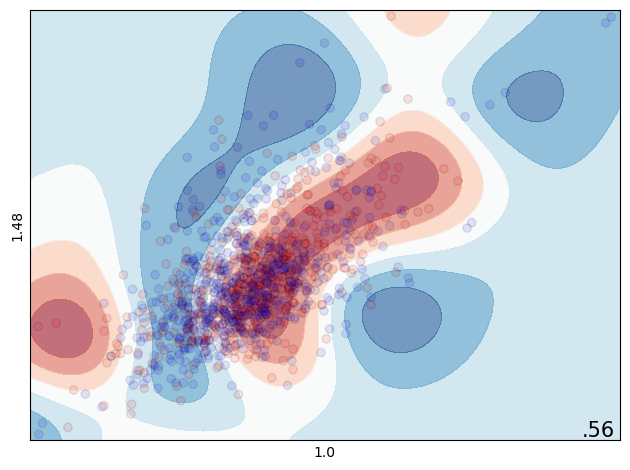

In [ ]:
if todo_GridSearch:
    score = grid_search.best_score_
    figure = plt.figure()
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    ax = plt.subplot(1, 1, 1)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )
    plt.tight_layout()
    plt.show()

## Partie 2 : Figure d'ouverture

Nous allons essayer de suivre la classification de time series par Keras
https://keras.io/examples/timeseries/timeseries_anomaly_detection/
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

### 1 - Easy
#### Classify on patients with most FOG


In [114]:
test_size = 0.2
DF_indiv = q12[(q12['Freq'] >= 27) & (q12['Freq'] <= 35)].groupby(['GoNogo', 'Loc', 'Channel', 'Subject', 'TrialNum', 'Time']).mean().drop(columns=['Freq']).reset_index()
DF_indiv = DF_indiv.drop(columns=['Channel']).groupby(['GoNogo', 'Loc', 'Subject', 'TrialNum', 'Time']).mean().reset_index()

In [68]:
print(np.unique(q12['Subject']))

patlist = q12[q12['Meta_FOG'] == 2]['Subject'].unique()
print(patlist)
print(q12[q12['Meta_FOG'] == 1]['Subject'].unique())
print(q01[q01['Meta_FOG'] == 1]['Subject'].unique())

# CLn + DEj + GAl + GUg + ROe + SAs



['ALb' 'CLn' 'DEj' 'GAl' 'GIs' 'GUg' 'ROe' 'SAs' 'VIj']
['CLn' 'DEj' 'GAl' 'GUg' 'ROe' 'SAs' 'VIj']
['ALb' 'CLn' 'DEj' 'GAl' 'GIs' 'GUg' 'ROe' 'SAs']
['ALb' 'CLn' 'DEj' 'GAl' 'GIs' 'GUg' 'ROe' 'SAs']


Patient: DEj - AS
RPC + LFP - Accuracy: 0.5714285714285714
LFP only - Accuracy: 0.2857142857142857
RPC only - Accuracy: 1.0
Patient: DEj - SM
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 0.5714285714285714
RPC only - Accuracy: 1.0


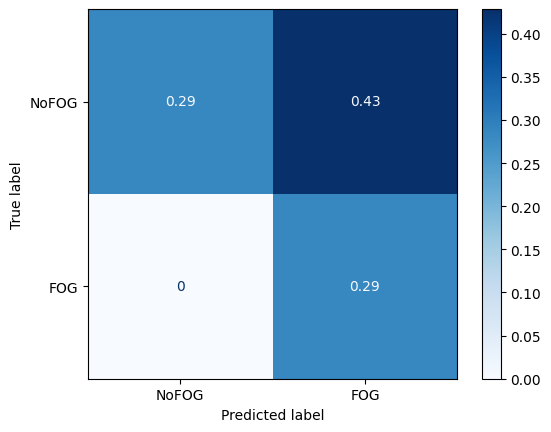

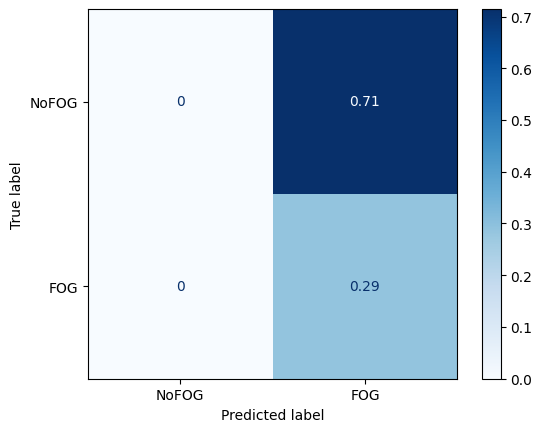

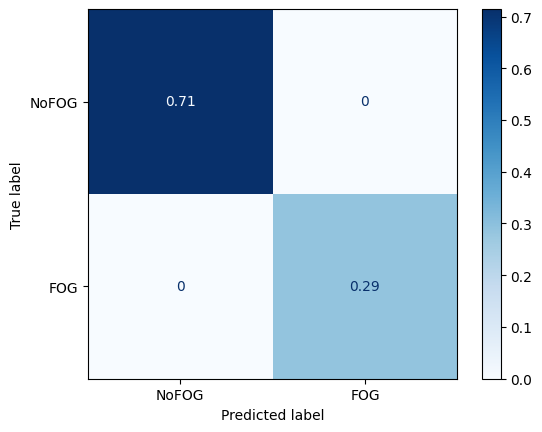

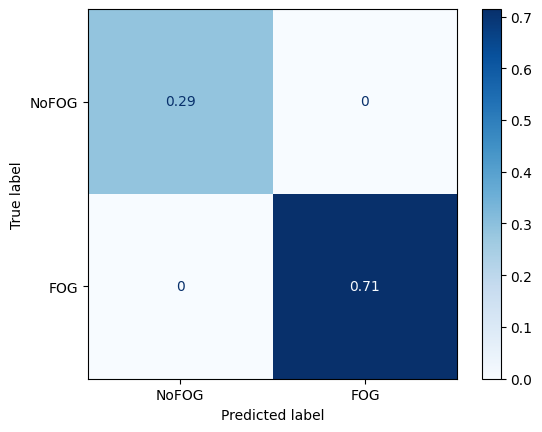

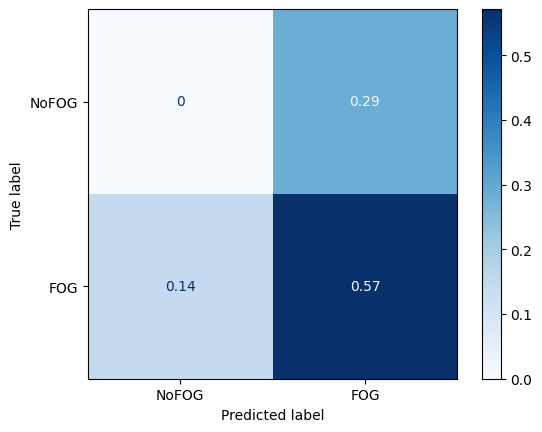

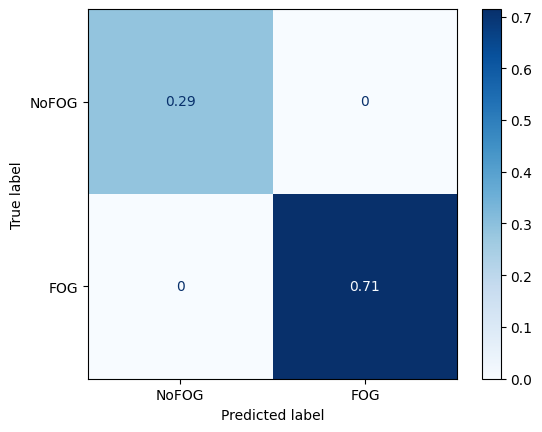

In [115]:
Patient = "DEj"

Loc = "AS"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Loc = "SM"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


In [118]:
Patient = "GAl"

Loc = "AS"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Patient: GAl - AS
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 1.0
RPC only - Accuracy: 1.0


In [117]:
Patient = "SAs"

Loc = "SM"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Patient: SAs - SM
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 1.0
RPC only - Accuracy: 1.0


In [121]:
Patient = "GUg"

Loc = "AS"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Loc = "SM"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Patient: GUg - AS
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 1.0
RPC only - Accuracy: 1.0
Patient: GUg - SM
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 1.0
RPC only - Accuracy: 1.0


In [123]:
Patient = "ROe"

Loc = "AS"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
iteration = 0
while True :
    iteration += 1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)
    if len(ytrain.unique()) == 2:
        break
    if iteration > 100:
        print("Too many iterations, no FOG+")
        error()

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Too many iterations, no FOG+


NameError: name 'error' is not defined

In [124]:
Patient = "CLn"

Loc = "AS"
DF_to_use = DF_indiv[(DF_indiv['Subject'] == Patient) & (DF_indiv['Loc'] == Loc)].drop(columns=['Subject', 'Loc'])
DF = DF_to_use.pivot_table(index=['TrialNum', 'GoNogo', 'Meta_FOG', 'RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'], columns=['Time'], values='Power').reset_index()

X = DF.drop(columns=['TrialNum', 'GoNogo', 'Meta_FOG'])
X.columns = X.columns.astype(str)
y = DF['Meta_FOG']
iteration = 0
while True :
    iteration += 1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=0)
    if len(ytrain.unique()) == 2:
        break
    if iteration > 100:
        print("Too many iterations, no FOG+")
        error()

clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Patient:", Patient + " - " + Loc)
print("RPC + LFP - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtr_ini, Xte_ini = Xtrain, Xtest
Xtrain, Xtest = Xtrain.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']), Xtest.drop(columns=['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5'])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("LFP only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

Xtrain, Xtest = Xtr_ini, Xte_ini
Xtrain, Xtest = Xtrain[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']], Xtest[['RPC.2', 'RPC.1', 'RPC.3', 'RPC.4', 'RPC.5']]
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("RPC only - Accuracy:", accuracy_score(ytest, ypred))
if len(ytest.unique()) == 2:
    disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')


Patient: CLn - AS
RPC + LFP - Accuracy: 1.0
LFP only - Accuracy: 1.0
RPC only - Accuracy: 1.0


# Brouillon

Idees pour le futur

In [127]:
q1 = q12[q12["Meta_FOG"] == 1]
q2 = q12[q12["Meta_FOG"] == 2]
q0 = q01[q01["Meta_FOG"] == 0]
concatenated = q1["Subject"] + q1["TrialNum"].astype(str) + q1["GoNogo"]
print(len(np.unique(concatenated)))
concatenated = q2["Subject"] + q2["TrialNum"].astype(str) + q2["GoNogo"]
print(len(np.unique(concatenated)))
concatenated = q0["Subject"] + q0["TrialNum"].astype(str) + q0["GoNogo"]
print(len(np.unique(concatenated)))

165
56
726


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Convert X and y to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.float)

# Create a TensorDataset and a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define the model
model = torch.nn.Linear(X.shape[1], 1)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the hyperparameters
learning_rates = [0.1, 1, 10]
epochs = [2, 3, 4]

# Grid search
for lr in learning_rates:
    for epoch in epochs:
        # Define the optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        for e in range(epoch):
            for batch in dataloader:
                # Forward pass
                pred = model(batch[0])
                loss = loss_fn(pred, batch[1])
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Calculate the RMSE
        with torch.no_grad():
            pred = model(X_tensor)
            rmse = torch.sqrt(loss_fn(pred, y_tensor))
        
        print(f"Learning rate: {lr}, Epochs: {epoch}, RMSE: {rmse}")